In [ ]:
import numpy as np
from urllib.request import urlopen
from tqdm import tqdm
import os.path
import time

class AlignedEmbeddingLoader(object):
  """This data loader will download an aligned fasttext embedding given a two letter language code.
  More information ca be found at https://fasttext.cc/docs/en/aligned-vectors.html ."""
  def __init__(self, lang='en'):
    """Data loader"""
    self._dataurl = "https://dl.fbaipublicfiles.com/fasttext/vectors-aligned/wiki.%s.align.vec" % lang
    cachefile = "cache_%s.npz" % lang
    if os.path.exists(cachefile):
      print("Loading cached data...", end="")
      t = time.time()
      data = np.load(cachefile)
      self.idx2token_ = list(data['idx2token'])
      self.vectors_ = data['vectors']
      print("done (%isec)" % (time.time()-t), flush=True)
    else:
      with urlopen(self._dataurl) as remote_file:
        get_decoded_line = lambda file: file.readline().decode('utf-8')
        self.n_tokens, self.n_dim = [int(n) for n in get_decoded_line(remote_file).split()]
        self.idx2token_ = list()
        self.vectors_ = np.zeros((self.n_tokens, self.n_dim), dtype=np.float32)
        for n in tqdm(range(self.vectors_.shape[0]), desc="Downloading and parsing vectors"):
          textline = get_decoded_line(remote_file)
          linedata = textline.split(' ')
          self.idx2token_.append(linedata[0])
          self.vectors_[n, :] = np.asarray(linedata[1:], dtype=np.float32)
      np.savez(cachefile, vectors=self.vectors_, idx2token=self.idx2token_)
    self.token2idx_ = {token:i for i, token in enumerate(self.idx2token_)}

loaded_embedding = AlignedEmbeddingLoader('en')

!ls -l

total 5196212
-rw-r--r-- 1 root root 5320910082 Jun 20 18:07 cache_en.npz
drwxr-xr-x 1 root root       4096 Jun 15 13:37 sample_data


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

class EmbeddingAnalyzer(object):
    def __init__(self, embedding):
        self.vectors_ = embedding.vectors_
        self.token2idx_ = embedding.token2idx_
        self.idx2token_ = embedding.idx2token_

    def __len__(self):
        """Gives the number of tokens in the embedding."""
        assert len(self.token2idx_) == len(self.idx2token)
        assert len(self.token2idx_) == self.vectors_.shape[0] # number of rows = number of tokens
        return len(self.token2idx_) 

    def __getitem__(self, tokens):
        """Returns the vectors for a token or a list of tokens."""
        assert type(tokens) == str or type(tokens) == list
        if type(tokens) == str:
            return self.vectors_[self.token2idx_[tokens]]
        else:
            # create an empty matrix with length of list (rows) and dimensionality (columns)
            mat = np.empty((len(tokens), self.vectors_.shape[1]))
            # add vectors to matrix!
            for i, token in enumerate(tokens):
                mat[i, :] = self.vectors_[self.token2idx_[token]]
            return mat

    def __contains__(self, token):
        """Allows a user query if a tokens is in the embedding."""
        return token in self.token2idx_ # OR token in self.idx2token_

    def projection(self, direction, vectors):
        """ 
        - INPUT (converted through __getitem__):
        direction:
            A vector
        vectors:
            A row matrix with word vectors
        - OUTPUT:
        The cosine similarity between a reference direction
        and a matrix of word vectors.  """
        if vectors.ndim == 1:
            return cosine_similarity(direction.reshape(1, -1), vectors.reshape(1, -1))
        newvecs = []
        for vector in vectors:
            newvecs.append(cosine_similarity(direction.reshape(1, -1), vector.reshape(1, -1))[0][0])
        return np.array(newvecs)

    # mat = np.empty((len(vectors), self.vectors_.shape[1]))
    # for i, vec in enumerate(vectors):
    #     vectors[i, :] = cosine_similarity(X=direction.reshape(1, -1), Y=vec.reshape(1, -1))
    # return vectors

    def simple_analogy(self, pair, query, k=5):
        """Simple/Classic word analogy as: man - woman = king - queen
            Equation: Query - Pair = x
        """
        x = self[query] - self[pair[0]] + self[pair[1]]
        project = np.argsort(self.projection(x, self.vectors_))
        return [self.idx2token_[token] for token in project[::-1][:k]]

    def similarity(self, token1, token2):
        """Returns the cosine similarity between two tokens."""
        assert token1 in self.token2idx_ and token2 in self.token2idx_
        return cosine_similarity(self[token1].reshape(1, -1), self[token2].reshape(1, -1))

    def analogies(self, analogy_direction, tokens):
        """The more complex word analogy method"""
        assert len(tokens) >= 2
        ret = []
        for i_1, token_1 in enumerate(tokens):
            best_CS = (None, 0)
            for i_2, token_2 in enumerate(tokens):
                if i_1 != i_2:
                    if euclidean_distances(self[token_1].reshape(1, -1), self[token_2].reshape(1, -1)) <= 1:
                        CS = cosine_similarity(analogy_direction.reshape(1, -1), self[token_1].reshape(1, -1) - self[token_2].reshape(1, -1))
                        if CS < best_CS[1]:
                            best_CS = (token_2, CS)
            if best_CS[0] != None:
                ret.append((token_1, best_CS[0]))
        return ret

analyzer = EmbeddingAnalyzer(loaded_embedding)

assert 'man' in analyzer.idx2token_ # OR assert 'man' in analyzer.token2idx_
assert 'woman' in analyzer.idx2token_ # OR assert 'woman' in analyzer.token2idx_
assert 'kdjfsfhgkdsjfdh' not in analyzer.idx2token_ # assert OR 'kdjfsfhgkdsjfdh' not in analyzer.token2idx_

assert len(analyzer.token2idx_) > 100000

assert type(analyzer['man']) is np.ndarray
assert np.isclose(np.sum(analyzer['man']-analyzer['man']), 0)

## Word similarity

We should be able to meassure similarity as cosine similarity.

$cos(\overrightarrow{cat}, \overrightarrow{dog}) \geq cos(\overrightarrow{cat}, \overrightarrow{cow})$

In [ ]:
assert analyzer.similarity('cat', 'dog') >= analyzer.similarity('cat', 'cow')
assert analyzer.similarity('eagle', 'falcon') >= analyzer.similarity('eagle', 'cow')

## Word analogies

One of the core tasks for showing any semantic properties in an embedding is finding word analogies. We can this of this as word a is to word b, as word c is to word d. Our task is to find word d, knowing a, b, and c.

$\overrightarrow{a} - \overrightarrow{b} \approx \overrightarrow{c} - \overrightarrow{d}$

For gender, this becomes:

$\overrightarrow{man} - \overrightarrow{woman} \approx \overrightarrow{king} - \overrightarrow{x}$

By rearranging we get:

$\overrightarrow{king} - \overrightarrow{man} + \overrightarrow{woman} \approx \overrightarrow{x}$

## Finding the genderedness of professions

Bulokbasi (2016) has a repo for the paper. We can download their data for professions. This allows us to find the genderedness for our embedding and plot against their survey data.

In [ ]:
import json
with urlopen('https://raw.githubusercontent.com/tolga-b/debiaswe/master/data/professions.json') as remote_file:
  professions = {title: {'definitional': defi, 'stereotypical': ster} for title, defi, ster in json.load(remote_file)}
print("Loaded %i professions" % len(professions))

Loaded 320 professions


We want to find the projection of vectors for different profession on a gender direction. This can be done by finding the cosine similarity as:

$cos(\overrightarrow{man} - \overrightarrow{woman}, \overrightarrow{butcher})$

$cos(\overrightarrow{man} - \overrightarrow{woman}, \overrightarrow{ballerina})$

The projection should be non-negative as $|cos(\cdot,\cdot)|$. However, by letting the projection method of the anlayzer give us the ccosine similarity, we can see the direction of the projection by looking at its sign.

In [ ]:
assert type(analyzer[['man', 'woman', 'butcher']]) is np.ndarray
assert analyzer[['man', 'woman', 'butcher']].shape[0] == 3

assert analyzer.projection(analyzer['man']-analyzer['woman'], analyzer['butcher'])  > 0
assert analyzer.projection(analyzer['man']-analyzer['woman'], analyzer['ballerina']) < 0

We create a woman-man direction.

In [ ]:
direction = analyzer['man']-analyzer['woman']
titles = [title for title in professions.keys() if title in analyzer]
projection = analyzer.projection(direction, analyzer[titles])

The estimation of the gender direction can be improved by using several pairs. Again, we use the data from Bulokbasi (2016).

In [ ]:
import json
with urlopen('https://raw.githubusercontent.com/tolga-b/debiaswe/master/data/definitional_pairs.json') as remote_file:
  definitional_pairs = [(m, f) for m, f in json.load(remote_file)]
definitional_pairs

[('woman', 'man'),
 ('girl', 'boy'),
 ('she', 'he'),
 ('mother', 'father'),
 ('daughter', 'son'),
 ('gal', 'guy'),
 ('female', 'male'),
 ('her', 'his'),
 ('herself', 'himself'),
 ('Mary', 'John')]

In [ ]:
direction2 = np.zeros(analyzer['man'].shape)
for female, male in definitional_pairs:
  direction2 += analyzer[male.lower()]
  direction2 -= analyzer[female.lower()]

projection2 = analyzer.projection(direction2, analyzer[titles])

In [ ]:
best_matches = analyzer.simple_analogy(('man', 'woman'), 'king', k=5)

best_matches
print("Matches (in order of similarity):")
for i, token in enumerate(best_matches):
  print(i+1, token)

assert 'queen' in analyzer.simple_analogy(('man', 'woman'), 'king', k=5)

Matches (in order of similarity):
1 king
2 queen
3 princess
4 regnant
5 princesses


We can do this for capitols too.

$\overrightarrow{France} - \overrightarrow{Japan} \approx \overrightarrow{Paris} - \overrightarrow{x}$

In [ ]:
best_matches = analyzer.simple_analogy(('france', 'japan'), 'paris', k=5)
print("Matches (in order of similarity):")
for i, token in enumerate(best_matches):
  print(i+1, token)

assert 'tokyo' in analyzer.simple_analogy(('france', 'japan'), 'paris', k=5)

Matches (in order of similarity):
1 tokyo
2 japan
3 osaka
4 kyoto
5 tokyo 


Please try doing this for at least one other famous category (e.g. comparing adjectives).

In [ ]:
best_matches = analyzer.simple_analogy(('hair', 'human'), 'fur', k=5)
print("Matches (in order of similarity):")
for i, token in enumerate(best_matches):
  print(i+1, token)

# assert 'animal' in analyzer.simple_analogy(('hair', 'human'), 'fur', k=5) (assumption - nonhuman is similar enough)

Matches (in order of similarity):
1 human
2 fur
3 human/nonhuman
4 #human
5 nonhuman


We can plot the relation between genderedness in the data and human annotation.

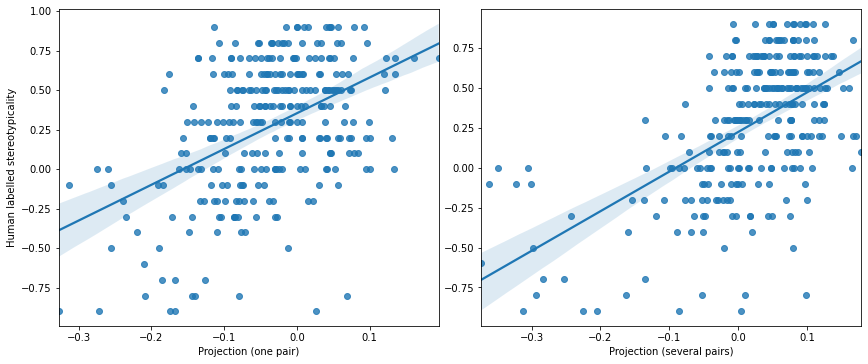

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(12, 5))
ax = fig.subplots(1, 2)
stereotypicality = [professions[title]['stereotypical'] for title in titles]
sns.regplot(x=projection, y=stereotypicality, ax=ax[0])
a = sns.regplot(x=projection2, y=stereotypicality, ax=ax[1])
ax[0].set_xlabel("Projection (one pair)")
ax[1].set_xlabel("Projection (several pairs)")
ax[0].set_ylabel("Human labelled stereotypicality")
fig.tight_layout(pad=.5)
fig.show()

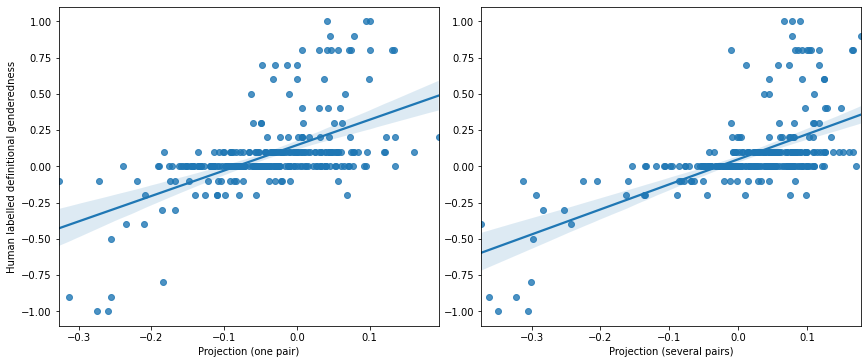

In [ ]:
fig = plt.figure(figsize=(12, 5))
ax = fig.subplots(1, 2)
definitionality = [professions[title]['definitional'] for title in titles]
sns.regplot(x=projection, y=definitionality, ax=ax[0])
a = sns.regplot(x=projection2, y=definitionality, ax=ax[1])
ax[0].set_xlabel("Projection (one pair)")
ax[1].set_xlabel("Projection (several pairs)")
ax[0].set_ylabel("Human labelled definitional genderedness")
fig.tight_layout(pad=.5)
fig.show()

## More analogies

The paper defines a more advances procedure for analogies as:

$S_{(a,b)}(x, y) = \left\{\begin{matrix}
cos(\overrightarrow{a}-\overrightarrow{b}, \overrightarrow{x}-\overrightarrow{y}) & \parallel \overrightarrow{x}-\overrightarrow{y} \parallel \leq 1\\ 
0 &  \text{otherwise}
\end{matrix}\right.$

This should return a list of tuples with word pairs.

In [ ]:
assert len(analyzer.analogies(analyzer['man']-analyzer['woman'], ['actor', 'actress'])) == 1
assert type(analyzer.analogies(analyzer['man']-analyzer['woman'], ['actor', 'actress'])) == list
assert type(analyzer.analogies(analyzer['man']-analyzer['woman'], ['actor', 'actress'])[0]) == tuple

analyzer.analogies(analyzer['man']-analyzer['woman'], ['actor', 'actress'])

[('actress', 'actor')]

In [ ]:
analyzer.analogies(analogy_direction=direction2, tokens=titles)

[('accountant', 'businessman'),
 ('acquaintance', 'tutor'),
 ('actress', 'actor'),
 ('adventurer', 'sportsman'),
 ('advocate', 'lawyer'),
 ('aide', 'colonel'),
 ('alderman', 'councilman'),
 ('alter_ego', 'vice_chancellor'),
 ('ambassador', 'diplomat'),
 ('analyst', 'commentator'),
 ('anthropologist', 'historian'),
 ('archaeologist', 'historian'),
 ('architect', 'industrialist'),
 ('artist', 'cartoonist'),
 ('artiste', 'entertainer'),
 ('assassin', 'gangster'),
 ('astronaut', 'scientist'),
 ('astronomer', 'philosopher'),
 ('athlete', 'sportsman'),
 ('attorney', 'congressman'),
 ('author', 'philosopher'),
 ('baker', 'butler'),
 ('ballerina', 'soloist'),
 ('ballplayer', 'sportswriter'),
 ('banker', 'financier'),
 ('barrister', 'businessman'),
 ('bartender', 'gangster'),
 ('biologist', 'physicist'),
 ('bishop', 'archbishop'),
 ('bodyguard', 'protege'),
 ('bookkeeper', 'salesman'),
 ('boss', 'gangster'),
 ('broadcaster', 'commentator'),
 ('broker', 'financier'),
 ('bureaucrat', 'steward'),
